<a href="https://colab.research.google.com/github/LM1997610/Social_Networks/blob/main/Project/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1><center>Social Networks and Online Markets</center></h1>
## <h2><center>Aris project</center></h2>
## <h4><center>2023/2024</center></h4>
## <h3><center>Luca Mazzucco: 1997610</center></h3>

In [1]:
! pip -q install scikit-network

In [2]:
import os
import sys
import warnings

import pickle
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.cm

from tqdm.auto import tqdm
from tabulate import tabulate
from collections import Counter
from IPython.display import Image

from sknetwork.data import load_netset

In [3]:
! git clone -q https://github.com/LM1997610/Social_Networks

if os.getcwd().split('/')[-1] != 'Social_Networks':
   os.chdir('Social_Networks/Project')

from visualize import topic_distrib_plot
from visualize import visualize_degree_distrib
from visualize import show_length_of_paths
from visualize import deg_separation_plot
from visualize import dead_end_plot
from visualize import in_out_plot

from visualize_graph import show_subnet
from visualize_graph import show_communities

output_dir = 'plot_folder'

if not os.path.exists(output_dir): os.makedirs(output_dir)

warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

fatal: destination path 'Social_Networks' already exists and is not an empty directory.


### **[WikiVitals](https://netset.telecom-paris.fr/pages/wikivitals.html)** dataset:
Vital articles of [Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:Vital_articles/Level/4) in English

In [4]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [5]:
label_id = {name: i for i, name in enumerate(wikivitals.names_labels)}

counted_topics = {category: Counter(wikivitals.labels)[id] for category, id in label_id.items()}

table_data = [(category, count) for category, count in counted_topics.items()]

print(tabulate(table_data, headers=["Label", "Counter"]))

Label                             Counter
------------------------------  ---------
Arts                                  673
Biological and health sciences       1479
Everyday life                         479
Geography                            1201
History                               680
Mathematics                           300
People                               1991
Philosophy and religion               435
Physical sciences                    1097
Society and social sciences           930
Technology                            746


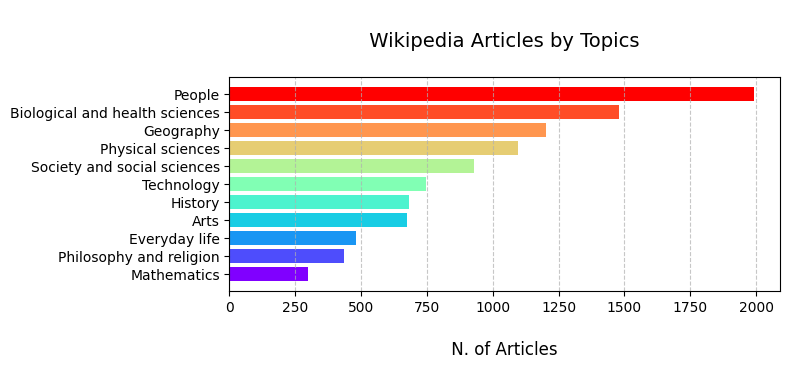

In [ ]:

topic_distrib_plot(counted_topics, output_directory = output_dir)

In [ ]:
adj_matrix = wikivitals.adjacency.toarray().astype(int)

G = nx.DiGraph(wikivitals.adjacency.toarray())
#G = nx.from_numpy_array(wikivitals.adjacency.toarray())

print()
print(f'Graph is undirected: {np.array_equal(adj_matrix, adj_matrix.T)}')
print(f'Graph is directed: {G.is_directed()}\n')

print(f'Number of nodes: {len(G.nodes)}')
print(f'Number of edges: {len(G.edges)}\n')

self_loops = list(nx.selfloop_edges(G))
G.remove_edges_from(self_loops)

print(f'>> removed {len(self_loops)}self-edge from the graph: {len(G.edges)} edges \n')

isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f'Number of isolated nodes: {len(isolated_nodes)}')


Graph is undirected: False
Graph is directed: True

Number of nodes: 10011
Number of edges: 824999

>> removed 1380self-edge from the graph: 823619 edges 

Number of isolated nodes: 0


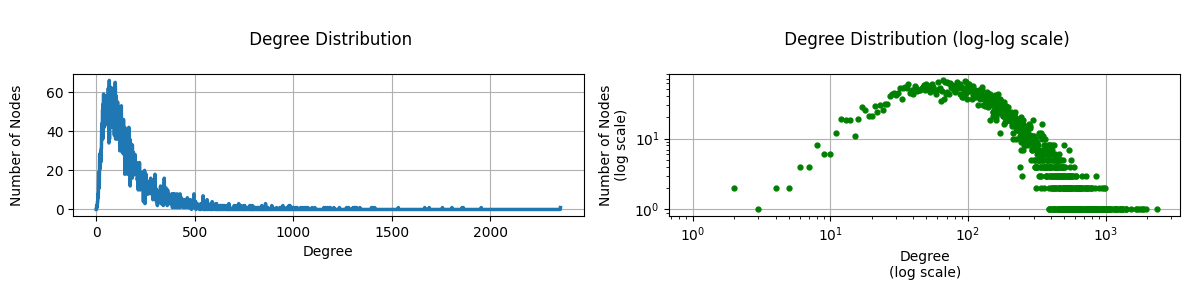

In [ ]:
degree_distrib = nx.degree_histogram(G)
nodes = [i for i in range(0, len(degree_distrib))]

degree_distrib = [degree_distrib[i] for i in range(len(degree_distrib))]

visualize_degree_distrib(nodes, degree_distrib, output_directory = output_dir)

In [ ]:
## For each topic, what are the most cited articles? → Edge analysis

def top_cited_articles(class_id, n):

  this_class = [x for x,y in enumerate(wikivitals.labels) if y == class_id]
  subgraph = G.subgraph(this_class)

  node_edge_counts = {node: subgraph.degree(node) for node in subgraph.nodes()}

  top_nodes = {k: v for k, v in sorted(node_edge_counts.items(), key=lambda item: item[1], reverse=True)}

  top_nodes_names = {wikivitals.names[idx]: count for idx, count in top_nodes.items()}

  return [(k, top_nodes_names[k]) for k in list(top_nodes_names)][:n]

In [ ]:
for i in range(11):

  this_label = [key for key in label_id.keys() if label_id[key] == i][0]
  this_top =  [x[0] for x in top_cited_articles(i, 5)]
  this_top = ["'" + s + "'" for s in this_top]

  print(f'{[this_label]} → {", ".join(this_top)}')

['Arts'] → 'Romanticism', 'Modernism', 'Symbolism (arts)', 'Modern art', 'Baroque'
['Biological and health sciences'] → 'Taxonomy (biology)', 'Animal', 'Chordate', 'Plant', 'Mammal'
['Everyday life'] → 'Marriage', 'Olympic Games', 'Softball', 'Rugby sevens', 'Association football'
['Geography'] → 'Geographic coordinate system', 'France', 'Europe', 'United States', 'China'
['History'] → 'Ottoman Empire', 'Roman Empire', 'Byzantine Empire', 'Russian Empire', 'British Empire'
['Mathematics'] → 'Mathematical analysis', 'Real number', 'Geometry', 'Function (mathematics)', 'Mathematics'
['People'] → 'Ralph Waldo Emerson', 'Aristotle', 'Bertrand Russell', 'Jean-Jacques Rousseau', 'Georg Wilhelm Friedrich Hegel'
['Philosophy and religion'] → 'Religion', 'Christianity', 'Taoism', 'Mysticism', 'Pantheism'
['Physical sciences'] → 'Oxygen', 'Hydrogen', 'Earth', 'Chemical element', 'Nitrogen'
['Society and social sciences'] → 'Slavery', 'Law', 'English language', 'Latin', 'European Union'
['Technol

## Wikipedia Races

The **[Wikipedia game](https://www.thewikipediagame.com/)** involves navigating from one Wikipedia page to another using as few steps/links as possible. \
Starting from a Wikipedia page on a topic, click blue links to move to other pages until reached the target page.\
The goal is to get the destination article as fast as possible using the fewest number of link clicks

In [ ]:
## WIKIPEDIA RACE

In [ ]:
def get_neighbors_at_levels(G, node, max_level=7):

    levels = {0: [node]}
    visited = {node}

    for level in range(1, max_level + 1):
        neighbors = set()

        for n in levels[level - 1]:
            neighbors.update(set(G.successors(n)) - visited)

        if not neighbors: break

        levels[level] = list(neighbors)
        visited.update(neighbors)

    return levels

In [ ]:
node_index = 2951

result = get_neighbors_at_levels(G, node_index, max_level=7)

print(f'Node: {wikivitals.names[2951]} - idx: {node_index}\n')

for k,v in result.items():
  print(f'level: {k} → connections reached: [{len(v)}]')

Node: Europe - idx: 2951

level: 0 → connections reached: [1]
level: 1 → connections reached: [679]
level: 2 → connections reached: [6927]
level: 3 → connections reached: [2354]
level: 4 → connections reached: [20]


In [ ]:
def cum_sum(una_lista):
  cumulative_sums = []
  cumulative_sum = 0
  for lst in una_lista.values():
      cumulative_sum += len(lst)
      cumulative_sums.append(cumulative_sum)

  return cumulative_sums

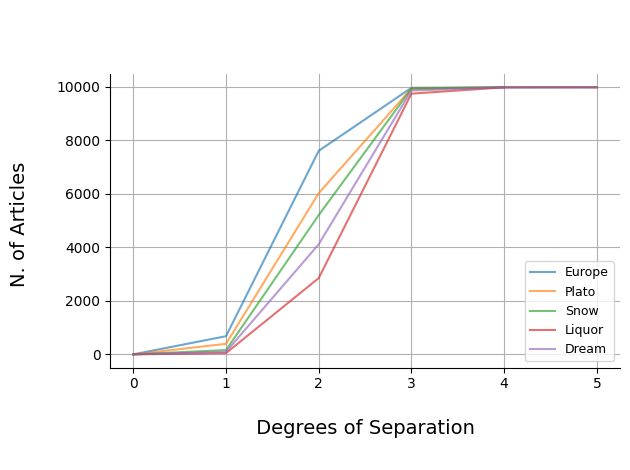

In [ ]:
indexes= [2951, 7108, 8319, 5365, 2526]

data = {}

for i in range(len(indexes)):

  results = get_neighbors_at_levels(G, indexes[i], max_level=8)
  data[wikivitals.names[indexes[i]]] = cum_sum(results)

data, table, not_reached = deg_separation_plot(data, total_nodes = len(list(G.nodes())), output_directory=output_dir )


In [ ]:
table_data = [ [key] + v for key, v in data.items()]
headers = ["Node"] + [f"Hop {i}" for i in range(7)]

print(tabulate(table_data, headers=headers, tablefmt="pretty"))

+--------+-------+-------+-------+-------+-------+-------+
|  Node  | Hop 0 | Hop 1 | Hop 2 | Hop 3 | Hop 4 | Hop 5 |
+--------+-------+-------+-------+-------+-------+-------+
| Europe |   1   |  680  | 7607  | 9961  | 9981  |       |
| Plato  |   1   |  395  | 6025  | 9936  | 9981  |       |
|  Snow  |   1   |  162  | 5206  | 9926  | 9980  | 9981  |
| Liquor |   1   |  48   | 2852  | 9743  | 9978  | 9981  |
| Dream  |   1   |  96   | 4115  | 9860  | 9980  | 9981  |
+--------+-------+-------+-------+-------+-------+-------+


In [ ]:
print(table, '\n')
print(f'Unreachable portion of the graph: {not_reached} %')

+--------+-----------+-----------+------------+------------+------------+------------+
|  Node  |   Hop 0   |   Hop 1   |   Hop 2    |   Hop 3    |   Hop 4    |   Hop 5    |
+--------+-----------+-----------+------------+------------+------------+------------+
| Europe | 0.00999 % | 6.79253 % | 75.98641 % | 99.50055 % | 99.70033 % |            |
| Plato  | 0.00999 % | 3.94566 % | 60.1838 %  | 99.25082 % | 99.70033 % |            |
|  Snow  | 0.00999 % | 1.61822 % | 52.0028 %  | 99.15093 % | 99.69034 % | 99.70033 % |
| Liquor | 0.00999 % | 0.47947 % | 28.48866 % | 97.32294 % | 99.67036 % | 99.70033 % |
| Dream  | 0.00999 % | 0.95895 % | 41.10478 % | 98.49166 % | 99.69034 % | 99.70033 % |
+--------+-----------+-----------+------------+------------+------------+------------+ 

Unreachable portion of the graph: 0.2997 %


----------------------------------------------------------------------

In [ ]:
def find_orphan_nodes(adjacency_matrix, graph):

    orphan_nodes = []

    for j in range(adjacency_matrix.shape[0]):

        if np.all(adjacency_matrix[:, j] == 0): orphan_nodes.append(j)

    for node in orphan_nodes:
      if list(graph.predecessors(node)): raise ValueError(f'Node {node} is not orphan!')

    return orphan_nodes

In [ ]:
def find_dead_ends(adjacency_matrix, graph):

    death_ends = []

    for i in range(adjacency_matrix.shape[0]):

        if np.all(adjacency_matrix[i, :] == 0): death_ends.append(i)

    for node in death_ends:
      if list(graph.successors(node)): raise ValueError(f'Node {node} is not dead end!')

    return death_ends

In [ ]:
total_nodes = len(list(G.nodes()))

orphan_nodes = find_orphan_nodes(adj_matrix, G)
death_ends = find_dead_ends(adj_matrix, G)

print()
print(f'total number of nodes: {total_nodes}')
print(f'number of Orphan nodes: {len(orphan_nodes)}')
print(f'number of DeadEnd nodes: {len(death_ends)}\n')

not_reachable = round( len(orphan_nodes)  / total_nodes * 100, 4)
#not_reachable = round((len(orphan_nodes) + len(death_ends)) / total_nodes * 100, 4)

print(f'Unreachable portion of the graph: {not_reachable} %')


total number of nodes: 10011
number of Orphan nodes: 30
number of DeadEnd nodes: 2

Unreachable portion of the graph: 0.2997 %


In [ ]:
# An orphan node can NOT be path destination -> Unreachable
# A DeadEnd node can NOT be path origin -> Unstartable

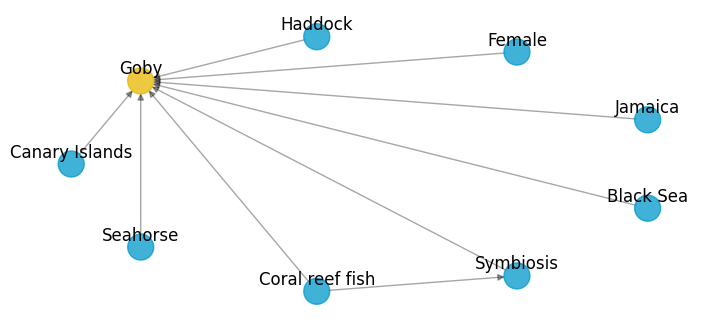

In [ ]:
dead_end_plot(G, death_ends[1], wikivitals.names)

--------------------------------------------------------
---------------------------------------------------------

### Average path length

In [ ]:
def dijkstra_shortest_path(graph, source, target):

    distances = {node: float('inf') for node in graph.nodes()}
    distances[source] = 0

    predecessors = {node: None for node in graph.nodes()}

    queue = [source]

    while queue:
        current_node = queue.pop(0)

        if current_node == target:
            path = []
            backtrack_node = current_node
            while backtrack_node is not None:
                path.insert(0, backtrack_node)
                backtrack_node = predecessors[backtrack_node]
            return path


        for neighbor in graph.neighbors(current_node):
            if distances[neighbor] == float('inf'):  # Se non è stato visitato
                distances[neighbor] = distances[current_node] + 1
                predecessors[neighbor] = current_node
                queue.append(neighbor)


    return []

In [ ]:
start_node_idx = 980   # Beer
end_node_idx = 997     # Belly dance

shortest_path = dijkstra_shortest_path(G, start_node_idx, end_node_idx)
## shortest_path = nx.dijkstra_path(G, start_node_idx, end_node_idx)

print('\n Start:', end = " ")

for i, idx_number in enumerate(shortest_path):

  print(f'[{wikivitals.names[idx_number]}] → ', end = "")

print('destination \n')
print(f'length = {len(shortest_path)} >> {shortest_path}')

## Start: [Belly dance] → [Africa] → [Germany] → [Beer] → destination
## length = 4 >> [997, 151, 3517, 980]


 Start: [Beer] → [Ancient Egypt] → [Egypt] → [Belly dance] → destination 

length = 4 >> [980, 422, 2680, 997]


In [ ]:
start_node_idx = 2988   # Exponential distribution
end_node_idx = 2071     # Corvus

shortest_path = dijkstra_shortest_path(G, start_node_idx, end_node_idx)

print('\n Start:', end = " ")
for i, idx_number in enumerate(shortest_path):

  print(f'[{wikivitals.names[idx_number]}] → ', end = "")

print(f'destination || len = {len(shortest_path)}')


 Start: [Exponential distribution] → [DNA] → [Animal] → [Bird] → [Common raven] → [Corvus] → destination || len = 6


In [ ]:
## Reverse path:
shortest_path = dijkstra_shortest_path(G, end_node_idx, start_node_idx)

print('\n Start:', end = " ")
for i, idx_number in enumerate(shortest_path):

  print(f'[{wikivitals.names[idx_number]}] → ', end = "")

print(f'destination || len = {len(shortest_path)}')


 Start: [Corvus] → [Animal] → [Rain] → [Exponential distribution] → destination || len = 4


In [ ]:
iterations = 20000

d = {}

if os.path.exists("length_of_paths.pickle"):
  with open("length_of_paths.pickle", 'rb') as f: d = pickle.load(f)

else:
  for i in tqdm(range(iterations)):

    node1, node2 = random.sample(list(G.nodes()), 2)

    # while node1 in death_ends or node2 in orphan_nodes:
      #  node1, node2 = random.sample(list(G.nodes()), 2)

    while (node1, node2) in d:
      node1, node2 = random.sample(list(G.nodes()), 2)

    shortest_path = dijkstra_shortest_path(G, node1, node2 )

    d[(node1, node2)] = shortest_path[1:]

  with open('length_of_paths.pickle', 'wb') as f: pickle.dump(d, f)

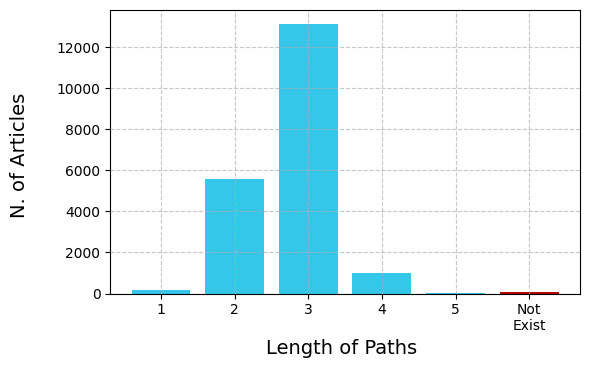



╒═══════════════════╤═════════════╤═════╤══════╤═══════╤══════╤═════╕
│ Lenght of path:   │  Not Exist  │  1  │  2   │   3   │  4   │  5  │
╞═══════════════════╪═════════════╪═════╪══════╪═══════╪══════╪═════╡
│ Nodes (couples):  │     58      │ 161 │ 5601 │ 13151 │ 1016 │ 13  │
╘═══════════════════╧═════════════╧═════╧══════╧═══════╧══════╧═════╛


In [ ]:
counter = dict(Counter(len(v) for v in d.values()))
sorted_counter = dict(sorted(counter.items()))

show_length_of_paths(sorted_counter, output_directory=output_dir )

In [ ]:
total_keys = sum(list(sorted_counter.values())[1:])

weighted_sum = sum(length * count for length, count in sorted_counter.items())

weighted_average = round(weighted_sum / total_keys, 2)

print(f"media ponderata {weighted_average}")

media ponderata 2.76


In [ ]:
## A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

In [ ]:
# nx.average_clustering(G)

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def spectral_embedding(G, k=2):
    # Ottenere la matrice di adiacenza
    A = nx.adjacency_matrix(G).todense()

    # Calcolare la matrice di grado
    D = np.diag(np.sum(A, axis=1))

    # Calcolare la matrice Laplaciana normalizzata
    L = np.eye(G.number_of_nodes()) - np.linalg.inv(D) @ A

    # Calcolare gli autovalori e gli autovettori
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Selezionare i primi k autovettori non nulli
    embedding = eigenvectors[:, 1:k+1]

    return embedding





In [ ]:
len(list(G.nodes))

10011

--------------------------------------------------------------------------
---------------------------------------------------------------------------

## Community Detection

In [ ]:
from wiki_graph_module import SubgraphBuilder

In [ ]:
label_id = {name: i for i, name in enumerate(wikivitals.names_labels)}

In [ ]:
graph_handler = {}

for topic_key in tqdm(label_id):

  builder = SubgraphBuilder(G, topic_key, label_id, wikivitals.labels, wikivitals.labels_hierarchy,
                                                    wikivitals.names_labels_hierarchy)
  graph_handler[builder.topic_name] = builder

  show_subnet(builder, show=False)
  print('{:>13} >> Nodes: {:>4} | Edges: {:>5} | Subclasses: {:>2} | Isolated: {:>2} | Components: {}'.format(*builder.info))

  0%|          | 0/11 [00:00<?, ?it/s]

       [Arts] >> Nodes:  666 | Edges: 11810 | Subclasses:  9 | Isolated:  7 | Components: 1
 [Biological] >> Nodes: 1479 | Edges: 55056 | Subclasses: 10 | Isolated:  0 | Components: 1
   [Everyday] >> Nodes:  479 | Edges:  9977 | Subclasses:  7 | Isolated:  0 | Components: 1
  [Geography] >> Nodes: 1201 | Edges: 88227 | Subclasses:  6 | Isolated:  0 | Components: 1
    [History] >> Nodes:  680 | Edges: 28519 | Subclasses: 11 | Isolated:  0 | Components: 1
[Mathematics] >> Nodes:  300 | Edges:  9659 | Subclasses:  7 | Isolated:  0 | Components: 1
     [People] >> Nodes: 1969 | Edges: 67077 | Subclasses: 15 | Isolated: 17 | Components: 3
 [Philosophy] >> Nodes:  435 | Edges: 24342 | Subclasses:  6 | Isolated:  0 | Components: 1
   [Physical] >> Nodes: 1097 | Edges: 60692 | Subclasses:  6 | Isolated:  0 | Components: 1
    [Society] >> Nodes:  929 | Edges: 26403 | Subclasses: 15 | Isolated:  1 | Components: 1
 [Technology] >> Nodes:  746 | Edges: 14086 | Subclasses: 17 | Isolated:  0 | Co

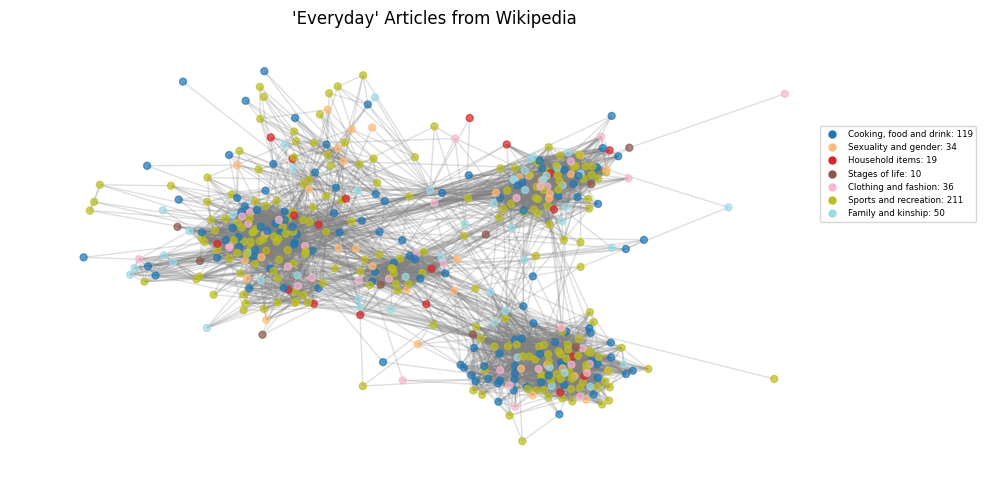

In [ ]:
community_label = "Everyday"

show_subnet(graph_handler[community_label], show=True)

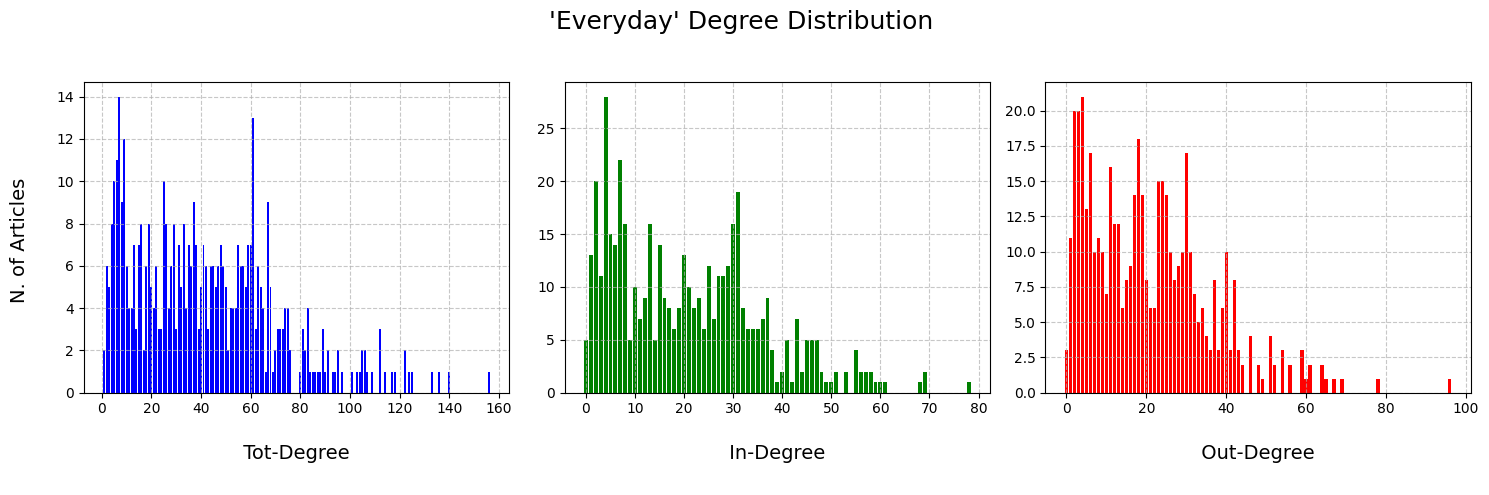

In [ ]:
degrees, in_deg, out_deg = graph_handler[community_label].compute_distribution()

in_out_plot(degrees, in_deg, out_deg, community_label, output_directory=output_dir)

In [ ]:
# Looking for Hubs: (percentile = 95)

for key in graph_handler.keys():

  hubs = graph_handler[key].find_hubs()

  print(f'{graph_handler[key].info[0]:>13} >> Hubs: {len(hubs)} -> {graph_handler[key].avg_clustering}', end =" ")
  average_clusstering_dir = round(nx.average_clustering(graph_handler[key].subgraph), 3)
  print(f'{average_clusstering_dir}')

  #graph_handler[key].visualize_hubs()

       [Arts] >> Hubs: 33 -> 0.381 0.331
 [Biological] >> Hubs: 74 -> 0.386 0.318
   [Everyday] >> Hubs: 24 -> 0.529 0.489
  [Geography] >> Hubs: 58 -> 0.525 0.431
    [History] >> Hubs: 34 -> 0.478 0.409
[Mathematics] >> Hubs: 15 -> 0.476 0.412
     [People] >> Hubs: 99 -> 0.424 0.416
 [Philosophy] >> Hubs: 22 -> 0.564 0.494
   [Physical] >> Hubs: 54 -> 0.428 0.397
    [Society] >> Hubs: 46 -> 0.35 0.298
 [Technology] >> Hubs: 38 -> 0.378 0.325


In [ ]:
## Centrality Measures:
## [Degree Centrality] - [Betweenness Centrality] - [Closeness Centrality] - [PageRank]

top_acrticles = {}

for key in graph_handler.keys():

  print(f'{graph_handler[key].info[0]:>13} >> ', end = '')
  top_acrticles[key] = graph_handler[key].get_all_centralities(wikivitals.names)

       [Arts] >> 

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


 [Biological] >> 

100%|██████████| 4/4 [01:05<00:00, 16.46s/it]


   [Everyday] >> 

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


  [Geography] >> 

100%|██████████| 4/4 [01:09<00:00, 17.41s/it]


    [History] >> 

100%|██████████| 4/4 [00:17<00:00,  4.41s/it]


[Mathematics] >> 

100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


     [People] >> 

100%|██████████| 4/4 [01:33<00:00, 23.32s/it]


 [Philosophy] >> 

100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


   [Physical] >> 

100%|██████████| 4/4 [00:49<00:00, 12.43s/it]


    [Society] >> 

100%|██████████| 4/4 [00:23<00:00,  5.92s/it]


 [Technology] >> 

100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


In [ ]:
print(top_acrticles["Arts"])

{'closeness_centrality': {'Romanticism': 0.53, 'Modernism': 0.516, 'Symbolism (arts)': 0.502}, 'betweenness_centrality': {'Romanticism': 0.056, 'Modernism': 0.042, 'Baroque': 0.035}, 'degree_centrality': {'Romanticism': 0.22, 'Modernism': 0.177, 'Baroque': 0.167}, 'pagerank': {'Romanticism': 0.007, 'Novel': 0.006, 'Modernism': 0.006}}


In [ ]:
## LOUVAIN

for topic_name, machine in tqdm(graph_handler.items()):

  partition = nx.community.louvain_communities(machine.subgraph.to_undirected())
  show_communities(machine, partition, show=False)


  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
!zip -r -q /outputs.zip /content/Social_Networks/Project/outputs

## Text Model



In [ ]:
! pip install --q -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00


In [ ]:
import torch
import seaborn as sns

from functools import partial
from datasets import Dataset

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from transformers import (AutoModel, AutoTokenizer)
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
articles_data = []

for i in tqdm(range(len(wikivitals.names))):

  word_indices = wikivitals.biadjacency[i].nonzero()[1]

  articles_data.append({
        'article_name': wikivitals.names[i],
        'words': " ".join([wikivitals['names_col'][i] for i in word_indices]),
        'label_name': wikivitals.names_labels[wikivitals.labels[i]],
        'label_index': wikivitals.labels[i]  })

df = pd.DataFrame(articles_data)

df.head()

  0%|          | 0/10011 [00:00<?, ?it/s]

,article_name,words,label_name,label_index
0,0,from historically identity system zero for be ...,Mathematics,5
1,1,can often from identity by neither matter most...,Mathematics,5
2,100 metres,straight Christian there often block less Cham...,Everyday life,2
3,14th Dalai Lama,family November establish Congressional religi...,People,6
4,1556 Shaanxi earthquake,city Ming wide live be on county Hunan More mi...,History,4


In [ ]:
def tokenize_function(example, tokenizer):
    out_dict = tokenizer(example["words"], truncation=True, padding=True)
    out_dict["label"] = example["label_index"]
    return out_dict

In [ ]:
train_val, test = train_test_split(df, test_size=0.09, random_state=42)

train, valid = train_test_split(train_val, test_size=0.15, random_state=42)

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test =  test.reset_index(drop=True)

print(f"Train size: {len(train)/len(df):>.3}")
print(f"Valid size: {len(valid)/len(df):>.3}")
print(f"Test size:  {len(test)/len(df):>.3}")

Train size: 0.773
Valid size: 0.137
Test size:  0.09


In [ ]:
train_ds = Dataset.from_pandas(train).map(
    partial(tokenize_function, tokenizer=tokenizer),
    batched=True,
    batch_size=len(train) )

val_ds = Dataset.from_pandas(valid).map(
    partial(tokenize_function, tokenizer=tokenizer),
    batched=True,
    batch_size=len(valid) )

test_ds = Dataset.from_pandas(test).map(
    partial(tokenize_function, tokenizer=tokenizer),
    batched=True,
    batch_size=len(test) )

Map:   0%|          | 0/7743 [00:00<?, ? examples/s]

Map:   0%|          | 0/1367 [00:00<?, ? examples/s]

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

In [ ]:
lr = 2e-5
n_epochs = 1
batch_size = 18
device = "cuda:0"
num_classes = 11
weight_decay = 1e-2

In [ ]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
model = AutoModel.from_pretrained(model_name)
classifier = torch.nn.Linear(768, num_classes)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optim = torch.optim.AdamW( list(model.parameters()) + list(classifier.parameters()),
                           lr=lr,
                           weight_decay=weight_decay )

lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR( optim, T_max=n_epochs, eta_min=0.01 * lr )

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    print(confusion_matrix(labels, predictions))
    return {"acc": accuracy_score(labels, predictions)}

In [ ]:
from tqdm.auto import tqdm

In [ ]:
model.to(device)
classifier.to(device)
for epoch in tqdm(range(n_epochs)):
    model.train()
    classifier.train()
    for iter, batch in enumerate(train_loader):
        input_ids = torch.stack(batch["input_ids"], 1).to(device)
        label = batch["label"].to(device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(device)

        features = model( input_ids=input_ids, attention_mask=attention_mask ).last_hidden_state[:, 0, :]

        logits = classifier(features)

        loss = criterion(logits, label)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if iter % 100 == 0:
            print(f" Epoch [{epoch+1}/{n_epochs}] - iter: [{iter:>3}/{len(train_loader)}] - loss {loss.item():>.3f}")

    lr_sched.step()

    loss_list = []
    pred_list = []
    label_list = []
    model.eval()
    classifier.eval()
    for iter, batch in enumerate(val_loader):
        input_ids = torch.stack(batch["input_ids"], 1).to(device)
        label = batch["label"].to(device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(device)

        with torch.no_grad():
            features = model(input_ids=input_ids, attention_mask=attention_mask ).last_hidden_state[:, 0, :]

            logits = classifier(features)

        loss = criterion(logits, label)
        loss_list.append(loss.item())
        pred_list += list(torch.argmax(logits, 1).cpu().squeeze())
        label_list += list(label.cpu())

    score = accuracy_score(label_list, pred_list)
    #print(confusion_matrix(label_list, pred_list))

    print(f" Epoch [{epoch+1}/{n_epochs}] -> Accuracy: {100*score:.4f}%")

    os.makedirs("outputs/text_model", exist_ok=True)

    torch.save({'model_state_dict': model.state_dict(),
                'classifier_state_dict': classifier.state_dict()},
                os.path.join("outputs/text_model", f"{model_name}_{100*score:.2f}.pth"))

    #torch.save(model.state_dict(),
    #           os.path.join("outputs/text_model", f"{model_name}_{100*score:.2f}.pth") )

  0%|          | 0/1 [00:00<?, ?it/s]

 Epoch [1/1] - iter: [  0/431] - loss 2.318
 Epoch [1/1] - iter: [100/431] - loss 0.653
 Epoch [1/1] - iter: [200/431] - loss 0.344
 Epoch [1/1] - iter: [300/431] - loss 0.541
 Epoch [1/1] - iter: [400/431] - loss 0.294
 Epoch [1/1] -> Accuracy: 89.9781%


In [ ]:
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

model_path = "/content/Social_Networks/Project/outputs/text_model/roberta-base_89.98.pth"

checkpoint = torch.load(model_path)

model.load_state_dict(checkpoint['model_state_dict'])
classifier.load_state_dict(checkpoint['classifier_state_dict'])

<ipython-input-26-170aa5d21d6e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


<All keys matched successfully>

In [ ]:
model.eval()
classifier.eval()

pred_list = []
label_list = []

# Evaluate the model on the test set:

with torch.no_grad():
  for iter, batch in tqdm(enumerate(test_loader), total=len(test_loader)):

        input_ids = torch.stack(batch["input_ids"], 1).to(device)
        label = batch["label"].to(device)
        attention_mask = torch.stack(batch["attention_mask"], 1).to(device)

        with torch.no_grad():
            features = model(input_ids=input_ids, attention_mask=attention_mask ).last_hidden_state[:, 0, :]
            logits = classifier(features)

        pred_list += list(torch.argmax(logits, 1).cpu().squeeze())
        label_list += list(label.cpu())

test_score = accuracy_score(label_list, pred_list)
conf_matrix = confusion_matrix(label_list, pred_list)

print(f"\n Test Accuracy: {100*test_score:.4f}% \n")

  0%|          | 0/50 [00:00<?, ?it/s]

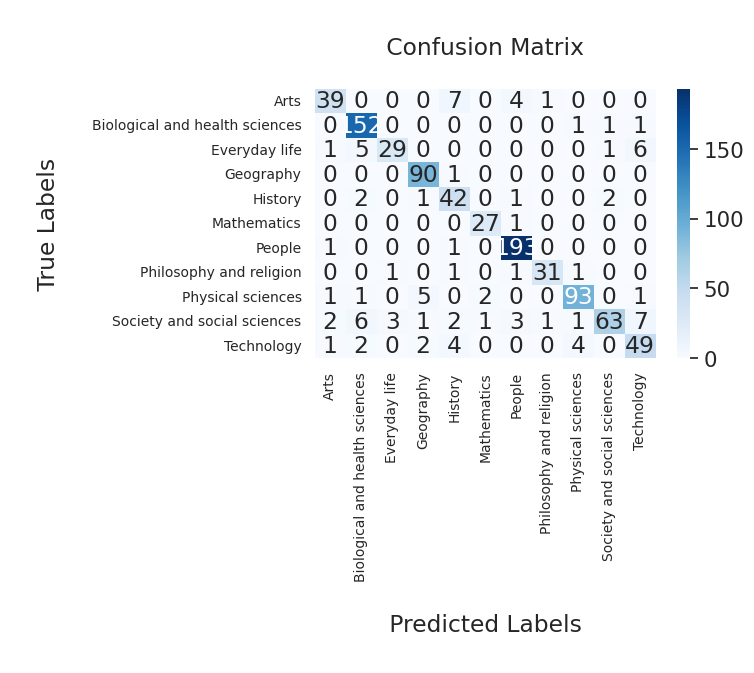

In [ ]:
plt.figure(figsize=(5.5, 3.5))
sns.set(font_scale=1.4)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=wikivitals.names_labels,
            yticklabels=wikivitals.names_labels)


plt.xlabel('\n Predicted Labels \n')
plt.ylabel('\n True Labels \n')
plt.title('\n Confusion Matrix \n')

plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

## Graph Model

In [5]:
! pip -q install torch_geometric

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, SAGEConv, GATConv

from torch_geometric.data import Data
import torch_geometric.transforms as T

In [7]:
adj_matrix = wikivitals.adjacency.toarray().astype(int)

G = nx.from_numpy_array(wikivitals.adjacency.toarray())

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 10011
Number of edges: 655192


In [8]:
node_features = []
node_labels = []

for node in tqdm(G.nodes()):

    word_indices = wikivitals.biadjacency[node].toarray()

    node_features.append(torch.tensor(word_indices, dtype=torch.float32).squeeze())
    node_labels.append(wikivitals.labels[node])

node_features_tensor = torch.stack(node_features)
node_labels_tensor = torch.tensor(node_labels, dtype=torch.long)

edge_index = torch.tensor(np.array(G.edges()).T, dtype=torch.long)
graph_data = Data(x=node_features_tensor, edge_index=edge_index, y=node_labels_tensor)

print(graph_data)

  0%|          | 0/10011 [00:00<?, ?it/s]

Data(x=[10011, 37845], edge_index=[2, 655192], y=[10011])


In [10]:
class GCN(nn.Module):
	def __init__(self, num_node_features, num_classes):
		super().__init__()

		self.conv1 = GCNConv(num_node_features, 256)
		self.conv2 = GCNConv(256, num_classes)

	def forward(self, data):
		x, edge_index = data.x, data.edge_index

		x = self.conv1(x, edge_index)
		x = F.relu(x)
		x = self.conv2(x, edge_index)

		return x

In [19]:
# ---------------------------------------------------------------------------------------#
def eval_node_classifier(model, graph, mask, is_test = False):

    model.eval()
    pred = model(graph).argmax(dim=1)
    correct	= (pred[mask] == graph.y[mask]).sum()
    acc = correct/mask.sum()

    true_p = ((pred[mask] == graph.y[mask]) & (pred[mask] == 1)).sum().item()
    false_p = ((pred[mask] != graph.y[mask]) & (pred[mask] == 1)).sum().item()
    false_n = ((pred[mask] != graph.y[mask]) & (pred[mask] == 0)).sum().item()

    precision = true_p / (true_p + false_p) if (true_p + false_p) > 0 else 0

    if is_test:
        recall = true_p / (true_p + false_n) if (true_p + false_n) > 0 else 0
        f1_score = (2*precision*recall)/(precision+recall)

        return (acc.item(), precision, recall, f1_score)

    return acc.item(), precision

# ---------------------------------------------------------------------------------------#
# ---------------------------------------------------------------------------------------#

def train_node_classifier(model, graph, optimizer, criterion, n_epochs = 200):

    train_lss_curve = []
    val_lss_curve = []

    evaluation = {"val_accuracy":[], "val_precision":[]}

    print("\n >> Training...\n")

    print(model, "\n")

    for epoch in range(1, n_epochs+1):
        model.train()
        optimizer.zero_grad()

        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        train_lss_curve.append(loss.item())

        loss.backward(retain_graph=True)
        optimizer.step()

        with torch.no_grad():

          val_loss = criterion(out[graph.val_mask], graph.y[graph.val_mask])
          val_lss_curve.append(val_loss.item())

          acc, precision = eval_node_classifier(model, graph, graph.val_mask)

        evaluation["val_accuracy"].append(acc)
        evaluation["val_precision"].append(precision)

        if epoch%10 == 0:
            print (f' Epoch [{epoch:>2}/{n_epochs}] | Loss: {loss.item():.4f} | Val_loss {val_loss.item():.4f} | Val_acc {acc:.3f} - ')

    print()
    return model, train_lss_curve, val_lss_curve, evaluation
# ---------------------------------------------------------------------------------------#
# ---------------------------------------------------------------------------------------#


In [20]:
# hyperparameters

lr = 0.01
wd = 5e-4
n_epochs = 50

split = T.RandomNodeSplit(num_val=0.2, num_test=0.01)
graph = split(graph_data)
graph

Data(x=[10011, 37845], edge_index=[2, 655192], y=[10011], train_mask=[10011], val_mask=[10011], test_mask=[10011])

In [21]:
model = GCN(num_node_features= 37845, num_classes=11)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = torch.nn.CrossEntropyLoss()

model, train_lss_curve, val_lss_curve, evaluation = train_node_classifier(model, graph,
                                                                          optimizer, criterion,
                                                                          n_epochs)

CONV_results = eval_node_classifier(model, graph, graph.test_mask, is_test=True)

print(f'\n Test accuracy: {CONV_results[0]:.3f}% \n')


 >> Training...

GCN(
  (conv1): GCNConv(37845, 256)
  (conv2): GCNConv(256, 11)
) 

 Epoch [10/50] | Loss: 3.1211 | Val_loss 3.1438 | Val_acc 0.455 - 
 Epoch [20/50] | Loss: 1.4388 | Val_loss 1.4489 | Val_acc 0.590 - 
 Epoch [30/50] | Loss: 0.9979 | Val_loss 1.0095 | Val_acc 0.624 - 
 Epoch [40/50] | Loss: 0.8883 | Val_loss 0.9158 | Val_acc 0.717 - 
 Epoch [50/50] | Loss: 0.7735 | Val_loss 0.8250 | Val_acc 0.733 - 


 Test accuracy: 0.730% 



In [31]:
gcn_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f' GCN total parameters: {gcn_total_params}')

 GCN total parameters: 9691403


In [30]:
module_path = '/content/Social_Networks/Homework'

if module_path not in sys.path: sys.path.append(module_path)

from Graph_NN import do_plot

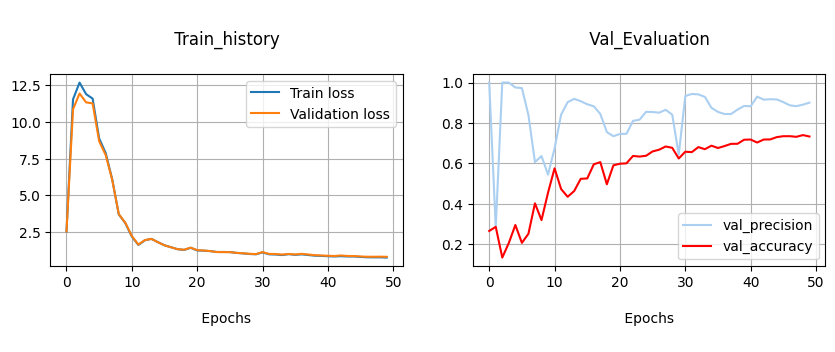

In [23]:
do_plot(n_epochs, train_lss_curve, val_lss_curve, evaluation)

--------------------------------------------
----------------------------------------------